In [22]:
import datashader as ds
import plotly.express as px
import polars as pl

pl.Config.set_tbl_width_chars(128)
pl.Config.set_fmt_str_lengths(128)

polars.config.Config

In [24]:
unit_born_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_born.ipc")
unit_died_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/unit_died.ipc")
orig_details_df = pl.scan_ipc("/home/seb/git/s2protocol-rs/ipcs/details.ipc")
freq_maps_df = (
    orig_details_df.group_by("title")
    .agg(pl.count())
    .filter(pl.col("count") > 25)
    .with_columns(pl.col("count").alias("map_count"))
    .select(["title", "map_count"])
)
details_df = orig_details_df.join(freq_maps_df, on="title", how="inner")
# unit_born_df.group_by("ext_replay_detail_player_name").agg(pl.count()).filter(
#    pl.col("count") > 10
# ).collect().sort("count", descending=True)#
# freq_maps_df.collect().sort("map_count", descending=True)
orig_details_df.select(
    [pl.col("ext_fs_replay_sha256"), pl.col("ext_datetime")]
).collect().sort("ext_datetime", descending=True)

ext_fs_replay_sha256,ext_datetime
str,datetime[ns]
"""bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606""",2023-09-01 16:27:20.513336
"""ca5319b603e1695072fe7ed503a4bee1e1cd2e21f0866b6d6a466675d8882053""",2023-09-01 16:07:19.388774
"""78522d042952fed26f959f43cd2d96b546f70ab6fea9c7c5d495c274ab92f4cc""",2023-09-01 15:58:14.462896
"""36fd9860aa778d0c5c38a46fd3653410de75b6271d7bf87331764426115c4e20""",2023-09-01 15:42:43.177646
"""d58b26a98c8c0ce7ae6ece61d20a0f567103139b24abcad3ea87aa31058cf220""",2023-09-01 15:26:07.515228
"""0d50ff17a2e5102fe7bc518acfcb6da0288c595ce8ba786cf4bc713a6da7d21a""",2023-09-01 15:01:38.400463
"""67f1dc4df940615db4a1bb0a19666e762a62aab97312d1ad48cc6c3c78b98eea""",2023-09-01 14:30:55.372892
"""e9dce9c415599c08b3d0f3180dfa01ce64dbadaad283cf83bfd53cd071b9c12d""",2023-08-30 17:46:52.934368
"""eded356f4f66bcedaccfdfb6a1c6a2ad98c8d0d8c8d0770f926f1414bcfbc9cd""",2023-08-30 17:25:46.633691


In [25]:
unit_born_ec_le = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (
            pl.col("ext_fs_replay_sha256")
            == "bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606"
        )
        & (pl.col("unit_type_name") != "InvisibleTargetDummy")
        & (~pl.col("unit_type_name").str.starts_with("Beacon"))
        & (~pl.col("unit_type_name").str.ends_with("Geyser"))
        & (~pl.col("unit_type_name").str.starts_with("LabMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("RichMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("MineralField"))
        & (pl.col("ext_replay_seconds") > 0)
    )
    .select(
        [
            pl.col("unit_type_name"),
            pl.col("unit_tag_index"),
            pl.col("unit_tag_recycle"),
            pl.col("creator_ability_name"),
            pl.col("ext_replay_seconds"),
            pl.col("ext_replay_detail_player_name"),
        ]
    )
)
unit_born_ec_le.collect().sort("ext_replay_seconds").head(5)

unit_type_name,unit_tag_index,unit_tag_recycle,creator_ability_name,ext_replay_seconds,ext_replay_detail_player_name
str,u32,u32,str,u32,str
"""Larva""",353,1,"""""",18,"""2-1-8459957-Sazed"""
"""Drone""",337,2,"""LarvaTrain""",20,"""2-1-8459957-Sazed"""
"""Larva""",359,1,"""""",37,"""2-1-8459957-Sazed"""
"""Drone""",338,2,"""LarvaTrain""",44,"""2-1-8459957-Sazed"""
"""Overlord""",336,2,"""LarvaTrain""",48,"""2-1-8459957-Sazed"""


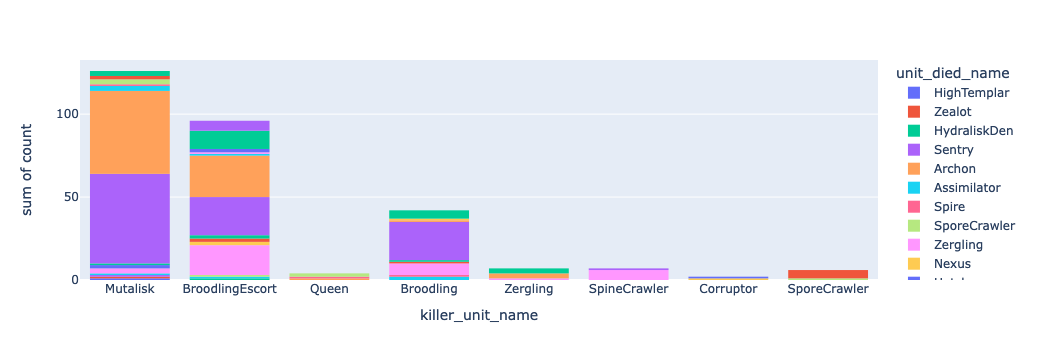

In [54]:
unit_died_ec_le = (
    unit_died_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_killer_player_name") == "2-1-8459957-Sazed")
        & (
            pl.col("ext_fs_replay_sha256")
            == "bcdc9f4529f33d8dc195e077a3efc8f2f5d171629589810258ce9c3b2884d606"
        )
        & (pl.col("killer_unit_name") != "")
    )
    .select(
        [
            pl.col("ext_replay_detail_killer_player_name"),
            pl.col("unit_died_name"),
            pl.col("unit_tag_index"),
            pl.col("killer_unit_name"),
            pl.col("killer_unit_tag_index"),
            pl.col("ext_replay_loop"),
            pl.col("ext_replay_seconds"),
        ]
    )
)
unit_died_freq = (
    unit_died_ec_le.group_by(["killer_unit_name","unit_died_name"])
    .agg(pl.count().alias("count"))
    .collect()
    .sort("count")
)
fig = px.histogram(unit_died_freq, x="killer_unit_name", y="count", color="unit_died_name")
fig.show()

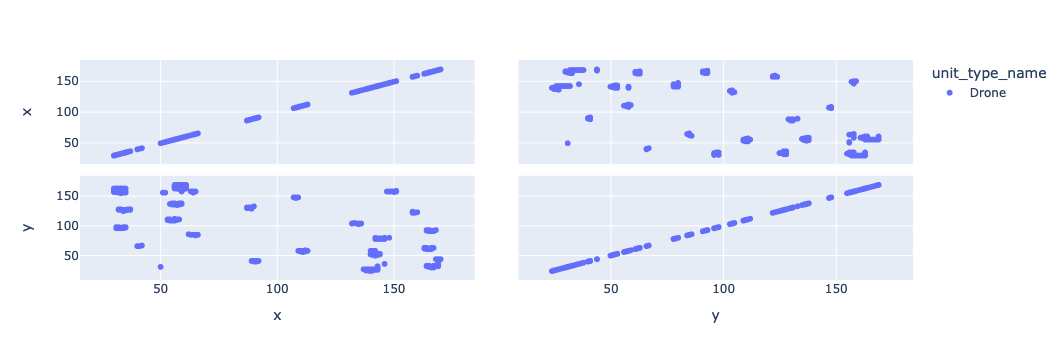

In [100]:
unit_born_ec_le = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("title") == "Emerald City LE")
        & (pl.col("unit_type_name") == "Drone")
    )
    .select([pl.col("x"), pl.col("y"), pl.col("unit_type_name")])
    .group_by(["x", "y", "unit_type_name"])
    .agg(pl.sum("unit_type_name").alias("count"))
    .collect()
)
fig = px.scatter_matrix(unit_born_ec_le, dimensions=["x", "y"], color="unit_type_name")
fig.show()

In [72]:
avg_drones_per_map = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("unit_type_name") == "Drone")
    )
    .select(
        [
            pl.col("title"),
            pl.col("ext_fs_replay_sha256"),
            pl.col("unit_type_name"),
            pl.col("ext_replay_loop"),
            pl.col("ext_replay_detail_datetime"),
        ]
    )
    .group_by(["title", "ext_fs_replay_sha256", "ext_replay_detail_datetime"])
    .agg(
        [
            pl.col("unit_type_name").count().alias("count"),
            pl.col("ext_replay_loop").max().alias("max_loop"),
        ]
    )
    .filter(pl.col("max_loop") > 50)
    .with_columns((pl.col("max_loop") / pl.col("count")).alias("avg_per_loop"))
    .collect()
)
avg_drones_per_map.sort("ext_replay_detail_datetime", descending=True)

title,ext_fs_replay_sha256,ext_replay_detail_datetime,count,max_loop,avg_per_loop
str,str,datetime[ns],u32,i64,f64
"""Emerald City LE""","""a50ee85be800266fc71cd354e41b98215d6f51131ff78c1241c341e14442934…",2023-08-24 13:58:26.788993,79,25464,322.329114
"""Reclamation LE""","""4dfd0152e5013d981dba3348971f3d50c66e3a747f7a4ef38187c0bda7843dc…",2023-08-24 13:40:00.903590,65,24485,376.692308
"""Heavy Artillery LE""","""1de5fba2ec377aab1fbf0d957120165ab2befcc4deaf6e4ee20d23cb1dca9ef…",2023-08-23 14:20:17.659160,18,2588,143.777778
"""Emerald City LE""","""9dda19ad9dcc21e8e546e9a9f9f56273950c3dcd26f2ff42eea401e81de72b4…",2023-08-18 15:37:52.141838,33,8483,257.060606
"""Reclamation LE""","""6021ff5bb9ebe0d6714d5fc482e57ecce26a3de0be6c3e233bfee06b3a1c43e…",2023-08-17 15:36:24.820907,76,19112,251.473684
"""Nightscape LE""","""d2c54d5dbdcfdcf78df719fcb4b2bc1ba531f24a9c14a24eee977b56010f1ed…",2023-08-17 15:24:20.246755,121,36988,305.68595
"""Fields of Death""","""f2d42aedad4d7f335127bff6ab5a7ed6973dd7e8ba146d53f7f08e1806940ca…",2023-08-13 15:52:11.005877,107,26004,243.028037
"""Fields of Death""","""43a07cea1def8d5bc76404e168a844d0f308e58030de21bb930940b95890ae6…",2023-08-13 15:33:28.145965,102,27491,269.519608
"""Reclamation LE""","""eb244e767744e2d2a5af8ac85de348b960022201b9be9455d34203e82fa13b2…",2023-08-13 15:18:31.650265,64,35073,548.015625


/home/seb/git/polars/venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



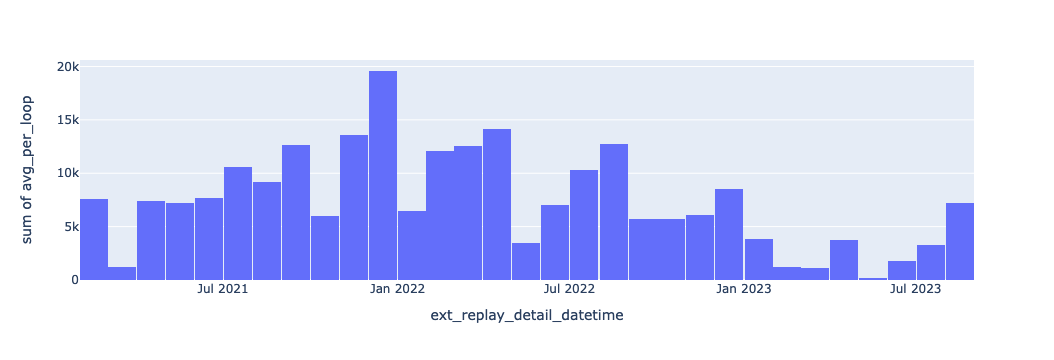

In [71]:
fig = px.histogram(avg_drones_per_map, x="ext_replay_detail_datetime", y="avg_per_loop")
fig.show()

In [ ]:
df_unit_born_details_join = (
    unit_born_df.join(details_df, on="ext_fs_replay_sha256", how="inner")
    .filter(
        (pl.col("ext_replay_detail_player_name") == "2-1-8459957-Sazed")
        & (pl.col("unit_type_name") != "InvisibleTargetDummy")
        & (~pl.col("unit_type_name").str.starts_with("Beacon"))
        & (~pl.col("unit_type_name").str.ends_with("Geyser"))
        & (~pl.col("unit_type_name").str.starts_with("LabMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("RichMineralField"))
        & (~pl.col("unit_type_name").str.starts_with("MineralField"))
    )
    .select([pl.col("title"), pl.col("unit_type_name")])
    .group_by(["title", "unit_type_name"])
    .agg(pl.col("unit_type_name").count().alias("count"))
    .filter(pl.col("count") > 200)
    .collect()
    .sort("count", descending=True)
)